In [1]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

In [3]:
# Load Datasets
mut_file = os.path.join('data', 'pancan_mutation_freeze.tsv')
sample_freeze_file = os.path.join('data', 'sample_freeze.tsv')
copy_loss_file = os.path.join('data', 'copy_number_loss_status.tsv')
copy_gain_file = os.path.join('data', 'copy_number_gain_status.tsv')
cancer_genes_file = os.path.join('data', 'vogelstein_cancergenes.tsv')

mutation_df = pd.read_table(mut_file, index_col=0)
sample_freeze = pd.read_table(sample_freeze_file, index_col=0)
copy_loss_df = pd.read_table(copy_loss_file, index_col=0)
copy_gain_df = pd.read_table(copy_gain_file, index_col=0)
cancer_genes_df = pd.read_table(cancer_genes_file)

In [4]:
# Load Ras Pathway Genes
results_path= os.path.join('classifiers', 'RAS')
genes_file = os.path.join(results_path, 'ras_genes.csv')
genes_df = pd.read_table(genes_file)

In [5]:
genes_df.head()

,genes,og_tsg
0,ALK,OG
1,ARAF,OG
2,BRAF,OG
3,EGFR,OG
4,ERBB2,OG


In [6]:
# Subset mutation data
mutation_sub_df = mutation_df.ix[:, genes_df['genes']]

In [7]:
# Find if the input genes are in this master list
genes_sub = cancer_genes_df[cancer_genes_df['Gene Symbol'].isin(genes_df['genes'])]

In [8]:
# Add status to the Y matrix depending on if the gene is a tumor suppressor
# or an oncogene. An oncogene can be activated with copy number gains, but
# a tumor suppressor is inactivated with copy number loss
tumor_suppressor = genes_df[genes_df['og_tsg'] == 'TSG']
oncogene = genes_df[genes_df['og_tsg'] == 'OG']

# Subset copy number information
copy_loss_sub_df = copy_loss_df[tumor_suppressor['genes']]
copy_gain_sub_df = copy_gain_df[oncogene['genes']]

## Output Mutation, Copy Number, and Total Heatmap (Gene by Cancer-type)

In [9]:
mutation_sub_total_df = mutation_sub_df.assign(Total=mutation_sub_df.max(axis=1))
mut_disease_df = mutation_sub_total_df.merge(sample_freeze, left_index=True,
                                             right_on='SAMPLE_BARCODE')
mut_heatmap_df = mut_disease_df.groupby('DISEASE').mean()

In [10]:
gene_avg = mut_disease_df.mean()
gene_avg.name = 'Total'

In [11]:
mut_heatmap_df = mut_heatmap_df.append(gene_avg)

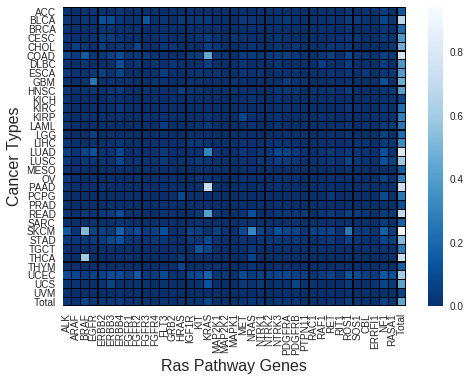

In [12]:
sns.set_style("whitegrid")
sns.heatmap(mut_heatmap_df, linewidths=0.2, linecolor='black', 
            cmap='Blues_r', square=True, cbar=True)
plt.ylabel('Cancer Types', fontsize=16)
plt.xlabel('Ras Pathway Genes', fontsize=16)
plt.savefig(os.path.join(results_path, 'mut_df.svg'))

In [13]:
copy_df = pd.concat([copy_gain_sub_df, copy_loss_sub_df], axis=1)
copy_total_df = copy_df.assign(Total=copy_df.max(axis=1))
copy_disease_df = copy_total_df.merge(sample_freeze, left_index=True,
                                      right_on='SAMPLE_BARCODE')
copy_heatmap_df = copy_disease_df.groupby('DISEASE').mean()

In [14]:
copy_avg = copy_disease_df.mean()
copy_avg.name = 'Total'

In [15]:
copy_heatmap_df = copy_heatmap_df.append(copy_avg)

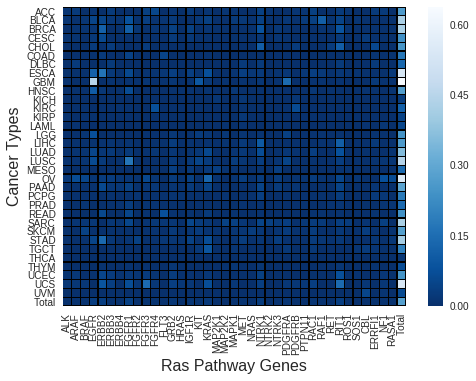

In [16]:
sns.set_style("whitegrid")
sns.heatmap(copy_heatmap_df, linewidths=0.2, linecolor='black', 
            cmap='Blues_r', square=True)
plt.ylabel('Cancer Types', fontsize=16)
plt.xlabel('Ras Pathway Genes', fontsize=16)
plt.savefig(os.path.join(results_path, 'copy_df.svg'))

In [17]:
# Combined heatmap
comb_heat = mutation_sub_df + copy_df
comb_heat[comb_heat == 2] = 1  # Replace duplicates with just one

In [18]:
comb_heat_df = comb_heat.merge(sample_freeze, left_index=True, right_on='SAMPLE_BARCODE')
comb_heat_total_df = comb_heat_df.assign(Total=comb_heat_df.max(axis=1))
comb_heatmap_df = comb_heat_total_df.groupby('DISEASE').mean()

In [19]:
comb_avg = comb_heat_total_df.mean()
comb_avg.name = 'Total'

In [20]:
comb_heatmap_plot = comb_heatmap_df.append(comb_avg)

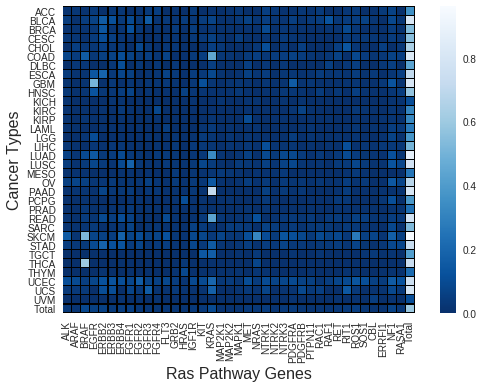

In [21]:
sns.set_style("whitegrid")
sns.heatmap(comb_heatmap_plot, linewidths=0.2, linecolor='black', 
            cmap='Blues_r', square=True)
plt.ylabel('Cancer Types', fontsize=16)
plt.xlabel('Ras Pathway Genes', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(results_path, 'combined_df.svg'))

## Generating Pathway Mapper Text Files

In [22]:
summary_score = pd.DataFrame([mut_heatmap_df.ix['Total', :], copy_heatmap_df.ix['Total', :]])
summary_score = summary_score.T
summary_score.columns = ['mutation', 'copy_number']
summary_score = summary_score * 100
summary_score = summary_score.round(decimals = 1)

In [23]:
tum_sup_mult = pd.Series([1] * 34 + [-1] * 4 + [1])
tum_sup_mult.index = summary_score.index

In [24]:
summary_score = summary_score.mul(tum_sup_mult, axis=0)
pathway_mapper_file = os.path.join(results_path, 'tables',
                                   'pathwaymapper_percentages.txt')
summary_score.to_csv(pathway_mapper_file, sep='\t')

## Output number of Ras events per sample

In [25]:
decision_file = os.path.join(results_path, 'classifier_decisions.tsv')
decisions_df = pd.read_table(decision_file)
decisions_df.head()

,SAMPLE_BARCODE,log10_mut,total_status,weight,HRAS,NRAS,KRAS,HRAS_gain,KRAS_gain,NRAS_gain,PATIENT_BARCODE,DISEASE,SUBTYPE,hypermutated,include
0,TCGA-02-0047-01,1.812913,0,0.357117,0,0,0,0,0,0,TCGA-02-0047,GBM,IDHwt,0,0
1,TCGA-02-0055-01,1.707570,0,0.530723,0,0,0,0,0,0,TCGA-02-0055,GBM,IDHwt,0,0
2,TCGA-02-2483-01,1.662758,0,0.642091,0,0,0,0,0,0,TCGA-02-2483,GBM,IDHmut-non-codel,0,0
3,TCGA-02-2485-01,1.748188,0,0.467431,0,0,0,0,0,0,TCGA-02-2485,GBM,IDHwt,0,0
4,TCGA-02-2486-01,1.755875,0,0.361267,0,0,0,0,0,0,TCGA-02-2486,GBM,IDHwt,0,0


In [26]:
total_ras_mutations = pd.DataFrame(mutation_sub_df.sum(axis=1), columns=['mutation_count'])
total_ras_copy_events = pd.DataFrame(copy_df.sum(axis=1), columns=['copy_count'])
total_ras_all = pd.DataFrame(comb_heat_df.sum(axis=1), columns=['all_count'])
total_ras_all.index = comb_heat_df['SAMPLE_BARCODE']

In [27]:
# Define output summary of mutation, copy, and total counts per sample by Ras pathway
count_summary = (
    decisions_df[['SAMPLE_BARCODE', 'DISEASE', 'weight']]
    .merge(total_ras_mutations, left_on='SAMPLE_BARCODE', right_index=True)
    )
hyper_samples = decisions_df[decisions_df['hypermutated'] == 1]['SAMPLE_BARCODE']
count_summary.ix[count_summary['SAMPLE_BARCODE'].isin(hyper_samples),
                 'mutation_count'] = 'hyper'
count_summary.head()

,SAMPLE_BARCODE,DISEASE,weight,mutation_count
0,TCGA-02-0047-01,GBM,0.357117,0
1,TCGA-02-0055-01,GBM,0.530723,0
2,TCGA-02-2483-01,GBM,0.642091,0
3,TCGA-02-2485-01,GBM,0.467431,1
4,TCGA-02-2486-01,GBM,0.361267,0


In [28]:
count_summary['mutation_count'].value_counts()

0        5079
1        2492
2         735
hyper     377
3         231
4         100
5          42
6          12
8           4
7           2
Name: mutation_count, dtype: int64

In [29]:
count_summary = total_ras_copy_events.merge(count_summary, left_index=True,
                                            right_on='SAMPLE_BARCODE')
count_summary = total_ras_all.merge(count_summary, left_index=True,
                                    right_on='SAMPLE_BARCODE')
count_summary = (
    decisions_df[['SAMPLE_BARCODE', 'total_status']]
    .merge(count_summary, left_on='SAMPLE_BARCODE', right_on='SAMPLE_BARCODE')
    )
count_summary.head()

,SAMPLE_BARCODE,total_status,all_count,copy_count,DISEASE,weight,mutation_count
0,TCGA-02-0047-01,0,0,0,GBM,0.357117,0
1,TCGA-02-0055-01,0,1,1,GBM,0.530723,0
2,TCGA-02-2483-01,0,1,1,GBM,0.642091,0
3,TCGA-02-2485-01,0,3,3,GBM,0.467431,1
4,TCGA-02-2486-01,0,0,0,GBM,0.361267,0


In [30]:
count_summary_file = os.path.join(results_path, 'tables',
                                  'ras_events_per_sample.tsv')
count_summary.to_csv(count_summary_file, sep='\t', index=False)